#### Import Libraries

In [1]:
import re
import requests
import numpy as np
import pandas as pd
from datetime import datetime, date

# for Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# for Web Scraping
import time
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait 
from selenium.webdriver.support import expected_conditions as EC

#### For WebScrapping

In [2]:
# user agent
my_user_agent = "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/143.0.7499.170 Safari/537.36"

# for BeautifulSoup
headers = {'User-Agent': my_user_agent}

# for selenium
options = Options()
options.add_argument("--headless")
options.add_argument(f"--user-agent={my_user_agent}")
options.add_argument("--disable-blink-features=AutomationControlled")
browser = webdriver.Chrome(options=options)

### NBA MVP Most Valuable Player Award Winners

In [3]:
mvp_url = "https://www.basketball-reference.com/awards/mvp.html"

tables = pd.read_html(mvp_url)
mvp_table = tables[0]
mvp_table.head()

Unnamed: 0_level_0 Unnamed: 1_level_0       Unnamed: 2_level_0  \
              Season                 Lg                   Player   
0            2024-25                NBA  Shai Gilgeous-Alexander   
1            2023-24                NBA             Nikola Jokić   
2            2022-23                NBA              Joel Embiid   
3            2021-22                NBA             Nikola Jokić   
4            2020-21                NBA             Nikola Jokić   

  Unnamed: 3_level_0 Unnamed: 4_level_0 Unnamed: 5_level_0 Unnamed: 6_level_0  \
              Voting                Age                 Tm                  G   
0                (V)                 26                OKC                 76   
1                (V)                 28                DEN                 79   
2                (V)                 28                PHI                 66   
3                (V)                 26                DEN                 74   
4                (V)                 25                DEN                 72   

  Per Game                            Shooting               Advanced         
        MP   PTS   TRB  AST  STL  BLK      FG%    3P%    FT%       WS  WS/48  
0     34.2  32.7   5.0  6.4  1.7  1.0    0.519  0.375  0.898     16.7  0.309  
1     34.6  26.4  12.4  9.0  1.4  0.9    0.583  0.359  0.817     17.0  0.299  
2     34.6  33.1  10.2  4.2  1.0  1.7    0.548  0.330  0.857     12.3  0.259  
3     33.5  27.1  13.8  7.9  1.5  0.9    0.583  0.337  0.810     15.2  0.296  
4     34.6  26.4  10.8  8.3  1.3  0.7    0.566  0.388  0.868     15.6  0.301

In [4]:
# create new dataframe 
mvp_data_list = []

for index in range(len(mvp_table)):
    data = tuple(mvp_table.iloc[index].values)
    mvp_data_list.append(data)  

df = pd.DataFrame(mvp_data_list, columns= ['Season','Lg','Player','Voting','Age','Tm','G','MP',
                                         'PTS','TRB','AST','STL', 'BLK','FG%','3P%','FT%','WS','WS/48'])
# delete 'Voting' columns
df.drop(columns="Voting", inplace=True)

df.head()

,Season,Lg,Player,Age,Tm,G,MP,PTS,TRB,AST,STL,BLK,FG%,3P%,FT%,WS,WS/48
0,2024-25,NBA,Shai Gilgeous-Alexander,26,OKC,76,34.2,32.7,5.0,6.4,1.7,1.0,0.519,0.375,0.898,16.7,0.309
1,2023-24,NBA,Nikola Jokić,28,DEN,79,34.6,26.4,12.4,9.0,1.4,0.9,0.583,0.359,0.817,17.0,0.299
2,2022-23,NBA,Joel Embiid,28,PHI,66,34.6,33.1,10.2,4.2,1.0,1.7,0.548,0.330,0.857,12.3,0.259
3,2021-22,NBA,Nikola Jokić,26,DEN,74,33.5,27.1,13.8,7.9,1.5,0.9,0.583,0.337,0.810,15.2,0.296
4,2020-21,NBA,Nikola Jokić,25,DEN,72,34.6,26.4,10.8,8.3,1.3,0.7,0.566,0.388,0.868,15.6,0.301


In [5]:
# save to excel
mvp_excel = df.to_excel("mvp_awards.xlsx", index=False)

#### Part1 - Extracting player information

##### Step1:

In [6]:
# --------- Get an alphabetical list of players --------
url = "https://www.basketball-reference.com/players/"

def get_alphabet_link(link):
    browser.get(link)
    # time.sleep(2)
    div_links = WebDriverWait(browser, 5).until( EC.presence_of_element_located((By.CLASS_NAME, "section_content")))

    # div_links = browser.find_element(By.CLASS_NAME, "section_content") 
    alphabet_link = div_links.find_elements(By.TAG_NAME, "a") 

    alphabet_link_list = []
    for link in alphabet_link:
        href = link.get_attribute("href")
        # print(href)
        alphabet_link_list.append(href)

    return alphabet_link_list

# list of alphabet page link
alphabet_links = get_alphabet_link(url)

##### Step 2:

In [7]:
# -------- Getting links to the names of each letter -----
def get_player_page_links(link):
    browser.get(link)
    time.sleep(3)
    
    table_link = browser.find_element(By.ID, "players") 

    player_link = table_link.find_elements(By.CSS_SELECTOR, "tbody tr th a") 
    player_link_list = []

    for link in player_link:
        href = link.get_attribute("href")
        # print(href)
        player_link_list.append(href)


    return player_link_list


##### Step 3:

##### *With Selenium*

In [8]:
def get_player_info(link):

    browser.get(link)
    div = browser.find_element(By.ID, "meta").text

    # To avoid errors
    name = None
    position = None
    shoots = None
    team = None
    died_date = None
    pts = None

    name = browser.find_element(By.CSS_SELECTOR, "h1").text

    # Position and Shoots
    if "Position" in div and "Shoots" in div:
        ps = div
        pos = re.search("Position:\s*(.+?)\s*▪ Shoots", ps)
        position = pos.group(1) 
        if "and" in position:
            position = position.replace("and","")
        else:
            position = position
                
        shot = re.search("Shoots:\s*([A-Za-z ]+)", ps)
        shoots = shot.group(1) 

    # Team
    if 'Team' in div:
        team_name = div
        teamr = re.search("Team:\s*([A-Za-z ]+)", team_name)
        team = teamr.group(1) 


    # Died date
    if "Died" in div:
        died_date = re.search("Died:(\s*(.+?)\d{4})", div).group(1).strip()
        #if len(d_died) > 4:
            #died_date = datetime.strptime(d_died, "%B %d, %Y").date()
        #else:
            #died_date = datetime(int(d_died), 1, 1).date()

    # PTS
    career = browser.find_element(By.CLASS_NAME, "stats_pullout").text 
    player_pts = re.findall(r"PTS\s+([\d\.]+)(?:\s+([\d\.]+))?", career)

    if player_pts:
        pts = player_pts[0][1]
    if pts == '':
        pts = player_pts[0][0] 


    # --- output ----
    return(name,
            position,
            shoots,
            team,
            died_date,
            pts
        )

##### *With BeautifulSoup*

In [ ]:
"""
def get_player_info(link):
    #browser.get(link)
    #time.sleep(2)
    #soup = BeautifulSoup(browser.page_source, 'html.parser')

    response = requests.get(link, headers=headers, timeout=30)
    soup = BeautifulSoup(response.text, 'html.parser')

    # div = soup.find("div" , class_="players")
    # div = soup.find("div" , id="meta") or soup.find("div" , class_= "nothumb") or soup.find("div" , class_="media-item")
    # div = soup.select_one("div#meta, div.nothumb, div.media-item")
    div = soup.find("div" , id="meta")
    p = div.find_all("p") 
    # p = div.find_all(["p", "span"]) 

    # To avoid errors
    name = None
    height = None
    weight = None
    position = None
    shoots = None
    team = None
    nationality = None 
    birth_date = None
    died_date = None
    age = None
    status = None
    experience = None
    pts = None

    # name 
    h1 = soup.find("h1") 
    if h1: 
        span = h1.find("span") 
        if span: 
            name = span.get_text(strip=True) 
        else: 
            name = h1.get_text(strip=True)

    # name = soup.find("h1").get_text(strip=True)
    
    for items in p:
        text_p = items.get_text(" ", strip=True)
        #print(text_p)

        # height and weight
        if "cm" in text_p and "kg" in text_p:
            hw = text_p
            hght = re.search("(\d+)cm", hw)
            height = hght.group(1) 
            wght = re.search("(\d+)kg", hw)
            weight = wght.group(1) 

        # Position and Shoots
        if "Position" in text_p and "Shoots" in text_p:
            ps = text_p
            pos = re.search("Position:\s*(.+?)\s*▪ Shoots", ps)
            position = pos.group(1) 
            if "and" in position:
                position = position.replace("and","")
            else:
                position = position
            
            shot = re.search("Shoots:\s*([A-Za-z ]+)", ps)
            shoots = shot.group(1) 

        # Born
        if "Born" in text_p:
            born = text_p
            nationality = re.search("in\s*(.+)", born).group(1).split()[-1]
            bdate = re.search("Born:(\s*(.+?)\d{4})", born).group(1).strip()
            birth_date = datetime.strptime(bdate, "%B %d , %Y").date()

        # Died
        if "Died" in text_p:
            died = text_p 
            d_died = re.search("Died:(\s*(.+?)\d{4})", died).group(1).strip()
            if len(d_died) > 4:
                died_date = datetime.strptime(d_died, "%B %d, %Y").date()
            else:
                died_date = datetime(int(d_died), 1, 1).date()
        
        # Team
        if 'Team' in text_p:
            team_name = text_p
            teamr = re.search("Team :\s*([A-Za-z ]+)", team_name)
            team = teamr.group(1) 

        # Experience
        if "Experience" in text_p:
            exp = text_p
            expr = re.search(r"\d+", exp)
            experience = expr.group() 


        # Calculate Age
        if birth_date and died_date:
            age = calculate_age(birth_date, died_date)
        elif birth_date:
            today = date.today() 
            age = calculate_age(birth_date, today)

        # Status
        if "Died" in text_p:
            status = "Deceased" 
        elif "Team" in text_p:
            status = "Active" 
        else:
            status = "Retired"

    # PTS
    text = soup.get_text(separator=" ", strip=True)
    player_pts = re.findall(r"PTS\s+([\d\.]+)(?:\s+([\d\.]+))?", text)

    if player_pts:
        pts = player_pts[0][1]
    if pts == '':
        pts = player_pts[0][0]


    # --- output ----
    return(name, 
           birth_date,
           died_date,
           age,
           status, 
           height, 
           weight, 
           nationality ,
           position, 
           shoots, 
           team,
           experience,
           pts
    )

"""       

##### For test

In [9]:
# --- for test and sea the result 
# --- If the output is correct, run the next cell.
url = "https://www.basketball-reference.com/players/j/jamesle01.html"

info = get_player_info(url)
info

('LeBron James',
 'Small Forward, Power Forward, Point Guard, Center,  Shooting Guard',
 'Right',
 'Los Angeles Lakers',
 None,
 '26.9')

##### Get Data from each Links

In [ ]:
# -------------- It takes too long -------------
"""
players_info = []

for alpha_link in alphabet_links:
    players_links = get_player_page_links(alpha_link)
    
    for player in players_links:
        print(player)
        info = get_player_info(player)
        players_info.append(info)
        time.sleep(3)

    time.sleep(4)

browser.quit() 
"""

##### Convert to DataFrame and Excel file

In [ ]:
"""
# convert to df
df_scraper = pd.DataFrame(players_info, columns=['Name',
                                                'Position',
                                                'Shoots',
                                                'Current Team',
                                                'Death date',
                                                'Pts'])
# convert to excel
scraper_excel = df_scraper.to_excel("scraper_info.xlsx", index=False)
"""

In [15]:
df_scraper = pd.read_excel("Dataset/scraper_info.xlsx")
df_scraper.head()

,Name,Position,Shoots,Current Team,Death date,Pts
0,Alaa Abdelnaby,Power Forward,Right,NaN,NaN,5.7
1,Zaid Abdul-Aziz,Center Power Forward,Right,NaN,NaN,9.0
2,Kareem Abdul-Jabbar,Center,Right,NaN,NaN,24.6
3,Mahmoud Abdul-Rauf,Point Guard,Right,NaN,NaN,14.6
4,Tariq Abdul-Wahad,Shooting Guard,Right,NaN,NaN,7.8


In [16]:
df_scraper.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5384 entries, 0 to 5383
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Name          5384 non-null   object 
 1   Position      5384 non-null   object 
 2   Shoots        5384 non-null   object 
 3   Current Team  515 non-null    object 
 4   Death date    1190 non-null   object 
 5   Pts           5384 non-null   float64
dtypes: float64(1), object(5)
memory usage: 252.5+ KB


#### Getting data from player tables

In [17]:
players_table_info = []

for link in alphabet_links:
    tables = pd.read_html(link)
    info = tables[0]
    players_table_info.append(info)
    # print(link)

# convert to df
table_df = pd.concat(players_table_info, ignore_index=True)

# change columns name
table_df.columns = ['Name', 'From', 'To', 'Positions','Height','Weight', 'Birth date', 'Colleges']
table_df.head()

,Name,From,To,Positions,Height,Weight,Birth date,Colleges
0,Alaa Abdelnaby,1991,1995,F-C,6-10,240.0,"June 24, 1968",Duke
1,Zaid Abdul-Aziz,1969,1978,C-F,6-9,235.0,"April 7, 1946",Iowa State
2,Kareem Abdul-Jabbar*,1970,1989,C,7-2,225.0,"April 16, 1947",UCLA
3,Mahmoud Abdul-Rauf,1991,2001,G,6-1,162.0,"March 9, 1969",LSU
4,Tariq Abdul-Wahad,1998,2003,F,6-6,223.0,"November 3, 1974","Michigan, San Jose State"


#### Change some columns

In [18]:
# height to cm
def ht_to_cm(ht):
    feet , inch = ht.split('-')
    h_cm = int(int(feet) * 30.48 + int(inch) * 2.54)

    return h_cm

table_df['Height'] = table_df['Height'].apply(ht_to_cm)

# weight to kg
table_df["Weight"].fillna(0)
table_df["Weight"] = round(table_df["Weight"] * 0.453592)

table_df.head()

,Name,From,To,Positions,Height,Weight,Birth date,Colleges
0,Alaa Abdelnaby,1991,1995,F-C,208,109.0,"June 24, 1968",Duke
1,Zaid Abdul-Aziz,1969,1978,C-F,205,107.0,"April 7, 1946",Iowa State
2,Kareem Abdul-Jabbar*,1970,1989,C,218,102.0,"April 16, 1947",UCLA
3,Mahmoud Abdul-Rauf,1991,2001,G,185,73.0,"March 9, 1969",LSU
4,Tariq Abdul-Wahad,1998,2003,F,198,101.0,"November 3, 1974","Michigan, San Jose State"


##### Step 4:

#### Merge table_df and df_scraper

In [19]:
# To remove extra spaces and make columns identical
table_df['Name'].str.strip()
df_scraper['Name'].str.strip()

# merge dfs
df_merged = table_df.merge(df_scraper, on="Name", how="left")
df_merged

,Name,From,To,Positions,Height,Weight,Birth date,Colleges,Position,Shoots,Current Team,Death date,Pts
0,Alaa Abdelnaby,1991,1995,F-C,208,109.0,"June 24, 1968",Duke,Power Forward,Right,NaN,NaN,5.7
1,Zaid Abdul-Aziz,1969,1978,C-F,205,107.0,"April 7, 1946",Iowa State,Center Power Forward,Right,NaN,NaN,9.0
2,Kareem Abdul-Jabbar*,1970,1989,C,218,102.0,"April 16, 1947",UCLA,NaN,NaN,NaN,NaN,NaN
3,Mahmoud Abdul-Rauf,1991,2001,G,185,73.0,"March 9, 1969",LSU,Point Guard,Right,NaN,NaN,14.6
4,Tariq Abdul-Wahad,1998,2003,F,198,101.0,"November 3, 1974","Michigan, San Jose State",Shooting Guard,Right,NaN,NaN,7.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5478,Ante Žižić,2018,2020,F-C,208,121.0,"January 4, 1997",NaN,Center,Right,NaN,NaN,6.0
5479,Jim Zoet,1983,1983,C,215,109.0,"December 20, 1953",Kent State University,Center,Right,NaN,NaN,0.3
5480,Bill Zopf,1971,1971,G,185,77.0,"June 7, 1948",Duquesne,Point Guard,Right,NaN,NaN,2.2
5481,Ivica Zubac,2017,2026,C,213,109.0,"March 18, 1997",NaN,Center,Right,Los Angeles Clippers,NaN,10.4


#### Change and Add some columns

In [20]:
def calculate_age(data):

    today = date.today()
    birthday = data["Birth date"]
    Deathday = data["Death date"] 

    if pd.isna(Deathday):
        second = today
    else:
        second = Deathday

    # from https://www.geeksforgeeks.org/python/python-program-to-calculate-age-in-year/ 
    age = second.year - birthday.year - ((second.month, second.day) <
                                            (birthday.month, birthday.day))
    return age

##### Step 5:

In [21]:
# delete Positions columns
df_merged.drop(columns="Positions", inplace=True)

# Add Status column
df_merged["Status"] = np.where(df_merged["To"] == 2026, 
                               "Active", 
                               np.where(df_merged["Death date"].notna(), "Deceased", "Retired"))

# Calculate Experience
df_merged["Experience"] = np.where(df_merged["Status"] == "Active" , df_merged["To"] - df_merged["From"], np.nan)

# Calculate Age
df_merged['Birth date'] = pd.to_datetime(df_merged['Birth date'], errors='coerce') 
df_merged['Death date'] = pd.to_datetime(df_merged['Death date'], errors='coerce')

df_merged["Age"] = df_merged.apply(calculate_age, axis=1)

df_merged['Birth date'] = df_merged['Birth date'].dt.date  # dont save time
df_merged['Death date'] = df_merged['Death date'].dt.date  

In [22]:
# Inserting a NaN Values with a '0'
fillna_list = ["Age", "Height", "Weight"]

for col in fillna_list:
    df_merged[col].fillna(value=0)

In [23]:
# Change the order of columns
columns = ['Name', 'From', 'To', 'Birth date','Death date','Age','Status','Colleges',
           'Height','Weight','Position','Shoots','Current Team','Experience','Pts']
 
df = df_merged[columns]
df.head()

,Name,From,To,Birth date,Death date,Age,Status,Colleges,Height,Weight,Position,Shoots,Current Team,Experience,Pts
0,Alaa Abdelnaby,1991,1995,1968-06-24,NaT,57.0,Retired,Duke,208,109.0,Power Forward,Right,NaN,NaN,5.7
1,Zaid Abdul-Aziz,1969,1978,1946-04-07,NaT,79.0,Retired,Iowa State,205,107.0,Center Power Forward,Right,NaN,NaN,9.0
2,Kareem Abdul-Jabbar*,1970,1989,1947-04-16,NaT,78.0,Retired,UCLA,218,102.0,NaN,NaN,NaN,NaN,NaN
3,Mahmoud Abdul-Rauf,1991,2001,1969-03-09,NaT,56.0,Retired,LSU,185,73.0,Point Guard,Right,NaN,NaN,14.6
4,Tariq Abdul-Wahad,1998,2003,1974-11-03,NaT,51.0,Retired,"Michigan, San Jose State",198,101.0,Shooting Guard,Right,NaN,NaN,7.8


##### duplicated Rows (after merge)

In [24]:
df[df['Name'].duplicated(keep=False)]

,Name,From,To,Birth date,Death date,Age,Status,Colleges,Height,Weight,Position,Shoots,Current Team,Experience,Pts
93,Dan Anderson,1968,1969,1943-02-15,NaT,82.0,Retired,Augsburg College,208,104.0,Center,Right,NaN,NaN,12.2
94,Dan Anderson,1968,1969,1943-02-15,NaT,82.0,Retired,Augsburg College,208,104.0,Point Guard Shooting Guard,Right,NaN,NaN,3.7
95,Dan Anderson,1975,1976,1951-01-01,NaT,75.0,Retired,USC,187,84.0,Center,Right,NaN,NaN,12.2
96,Dan Anderson,1975,1976,1951-01-01,NaT,75.0,Retired,USC,187,84.0,Point Guard Shooting Guard,Right,NaN,NaN,3.7
495,Bill Bradley,1968,1968,1941-06-16,2002-06-05,60.0,Deceased,Tennessee State,180,75.0,Shooting Guard,Right,NaN,NaN,3.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5347,Bobby Wilson,1975,1978,1951-01-15,NaT,75.0,Retired,Wichita State,190,79.0,Shooting Guard,Right,NaN,NaN,5.5
5418,Chris Wright,2012,2014,1988-09-30,NaT,37.0,Retired,Dayton,203,103.0,Small Forward,Right,NaN,NaN,3.7
5419,Chris Wright,2012,2014,1988-09-30,NaT,37.0,Retired,Dayton,203,103.0,Shooting Guard,Right,NaN,NaN,0.7
5420,Chris Wright,2013,2013,1989-11-04,NaT,36.0,Retired,Georgetown,185,95.0,Small Forward,Right,NaN,NaN,3.7


In [25]:
# If the name and age are the same, keep the one with fewer Pts
df["index"] = df.index 
df_sort_pts = df.sort_values("Pts", ascending=True)
df_drop = df_sort_pts.drop_duplicates(subset=["Name", "Age"], keep="first")
df_drop = df_drop.drop_duplicates(subset=['Name','Height', 'Weight'], keep="first")

# sort by index, then delete index columns
df_index = df_drop.sort_values("index")
df = df_index
df

C:\Users\ATOUS\AppData\Local\Temp\ipykernel_17484\2967966571.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["index"] = df.index


,Name,From,To,Birth date,Death date,Age,Status,Colleges,Height,Weight,Position,Shoots,Current Team,Experience,Pts,index
0,Alaa Abdelnaby,1991,1995,1968-06-24,NaT,57.0,Retired,Duke,208,109.0,Power Forward,Right,NaN,NaN,5.7,0
1,Zaid Abdul-Aziz,1969,1978,1946-04-07,NaT,79.0,Retired,Iowa State,205,107.0,Center Power Forward,Right,NaN,NaN,9.0,1
2,Kareem Abdul-Jabbar*,1970,1989,1947-04-16,NaT,78.0,Retired,UCLA,218,102.0,NaN,NaN,NaN,NaN,NaN,2
3,Mahmoud Abdul-Rauf,1991,2001,1969-03-09,NaT,56.0,Retired,LSU,185,73.0,Point Guard,Right,NaN,NaN,14.6,3
4,Tariq Abdul-Wahad,1998,2003,1974-11-03,NaT,51.0,Retired,"Michigan, San Jose State",198,101.0,Shooting Guard,Right,NaN,NaN,7.8,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5478,Ante Žižić,2018,2020,1997-01-04,NaT,29.0,Retired,NaN,208,121.0,Center,Right,NaN,NaN,6.0,5478
5479,Jim Zoet,1983,1983,1953-12-20,NaT,72.0,Retired,Kent State University,215,109.0,Center,Right,NaN,NaN,0.3,5479
5480,Bill Zopf,1971,1971,1948-06-07,NaT,77.0,Retired,Duquesne,185,77.0,Point Guard,Right,NaN,NaN,2.2,5480
5481,Ivica Zubac,2017,2026,1997-03-18,NaT,28.0,Active,NaN,213,109.0,Center,Right,Los Angeles Clippers,9.0,10.4,5481


##### Step 6: Save Data to excel files

In [26]:
# delete index columns
df.drop(columns="index", inplace=True)

info_excel = df.to_excel("Players_info.xlsx", index=False)

#### Draw graphs and binning

In [27]:
def show_plot(data,column):

    fig , axes = plt.subplots(1,2, figsize=(12,5))

    # BarPlot
    info = data.groupby([column]).size()
    axes[0].bar(info.index, info.values)
    axes[0].set_title(f"{column}")

    # Boxplot
    sns.boxplot(x=data[column], ax=axes[1])
    axes[1].set_title(f"{column}")
    
    plt.tight_layout()
    plt.show()

In [28]:
def binning(data,column,bins, labels):

    # binning
    col_bin = pd.cut(data[column],
                     bins=bins,
                     labels=labels,
                     include_lowest=True)
    
    # required data for plot
    freq = col_bin.value_counts().to_frame()

    fig, axes = plt.subplots(1,2, figsize=(12,5))

    # HeatMap
    freq["Percentage"] = (freq / freq.sum()) * 100
    sns.heatmap(freq, annot=True, fmt='.2f', cbar=False,
                cmap=["white"], linecolor="lightgray", linewidths=0.5, ax=axes[0])
    
    # BarPlot
    freq["count"].plot(kind='bar', ax=axes[1])

    plt.tight_layout()
    plt.show()

### 

## EDA - MVP List

In [29]:
df_mvp = pd.read_excel("mvp_awards.xlsx")
df_mvp.head()

,Season,Lg,Player,Age,Tm,G,MP,PTS,TRB,AST,STL,BLK,FG%,3P%,FT%,WS,WS/48
0,2024-25,NBA,Shai Gilgeous-Alexander,26,OKC,76,34.2,32.7,5.0,6.4,1.7,1.0,0.519,0.375,0.898,16.7,0.309
1,2023-24,NBA,Nikola Jokić,28,DEN,79,34.6,26.4,12.4,9.0,1.4,0.9,0.583,0.359,0.817,17.0,0.299
2,2022-23,NBA,Joel Embiid,28,PHI,66,34.6,33.1,10.2,4.2,1.0,1.7,0.548,0.330,0.857,12.3,0.259
3,2021-22,NBA,Nikola Jokić,26,DEN,74,33.5,27.1,13.8,7.9,1.5,0.9,0.583,0.337,0.810,15.2,0.296
4,2020-21,NBA,Nikola Jokić,25,DEN,72,34.6,26.4,10.8,8.3,1.3,0.7,0.566,0.388,0.868,15.6,0.301


In [30]:
df_mvp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70 entries, 0 to 69
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Season  70 non-null     object 
 1   Lg      70 non-null     object 
 2   Player  70 non-null     object 
 3   Age     70 non-null     int64  
 4   Tm      70 non-null     object 
 5   G       70 non-null     int64  
 6   MP      70 non-null     float64
 7   PTS     70 non-null     float64
 8   TRB     70 non-null     float64
 9   AST     70 non-null     float64
 10  STL     52 non-null     float64
 11  BLK     52 non-null     float64
 12  FG%     70 non-null     float64
 13  3P%     46 non-null     float64
 14  FT%     70 non-null     float64
 15  WS      70 non-null     float64
 16  WS/48   70 non-null     float64
dtypes: float64(11), int64(2), object(4)
memory usage: 9.4+ KB


#### Names of players on the mvp list

In [31]:
mvp_players_name = df_mvp["Player"].unique()
print(f"count of player in mvp list:{len(mvp_players_name)}\n{mvp_players_name}")

count of player in mvp list:37
['Shai Gilgeous-Alexander' 'Nikola Jokić' 'Joel Embiid'
 'Giannis Antetokounmpo' 'James Harden' 'Russell Westbrook'
 'Stephen Curry' 'Kevin Durant' 'LeBron James' 'Derrick Rose'
 'Kobe Bryant' 'Dirk Nowitzki' 'Steve Nash' 'Kevin Garnett' 'Tim Duncan'
 'Allen Iverson' "Shaquille O'Neal" 'Karl Malone' 'Michael Jordan'
 'David Robinson' 'Hakeem Olajuwon' 'Charles Barkley' 'Magic Johnson'
 'Larry Bird' 'Moses Malone' 'Julius Erving' 'Kareem Abdul-Jabbar'
 'Bill Walton' 'Bob McAdoo' 'Dave Cowens' 'Willis Reed' 'Wes Unseld'
 'Wilt Chamberlain' 'Bill Russell' 'Oscar Robertson' 'Bob Pettit'
 'Bob Cousy']


#### *Top 10 players who have received the most awards*

In [32]:
count_win_mvp = df_mvp.groupby(["Player"])["Season"].count().reset_index()
count_win_mvp.sort_values("Season", ascending=False)[:10]

,Player,Season
16,Kareem Abdul-Jabbar,6
24,Michael Jordan,5
1,Bill Russell,5
36,Wilt Chamberlain,4
22,LeBron James,4
21,Larry Bird,3
23,Magic Johnson,3
26,Nikola Jokić,3
25,Moses Malone,3
32,Steve Nash,2


#### *Top 10 players who have scored the most goals*

In [33]:
top_goals_mvp = df_mvp.groupby(["Player"])["G"].sum().reset_index()
top_goals_mvp.sort_values("G", ascending=False)[:10]

,Player,G
16,Kareem Abdul-Jabbar,490
24,Michael Jordan,408
1,Bill Russell,379
36,Wilt Chamberlain,314
22,LeBron James,295
21,Larry Bird,241
25,Moses Malone,241
23,Magic Johnson,236
26,Nikola Jokić,225
33,Tim Duncan,163


#### *Top 10 players with the most PTS points*

In [34]:
pts_mvp =df_mvp.groupby(["Player"])["PTS"].sum().reset_index()
pts_mvp.sort_values("PTS", ascending=False)[:10]

,Player,PTS
16,Kareem Abdul-Jabbar,172.2
24,Michael Jordan,155.7
36,Wilt Chamberlain,119.5
22,LeBron James,112.0
1,Bill Russell,83.3
25,Moses Malone,80.4
26,Nikola Jokić,79.9
21,Larry Bird,78.7
23,Magic Johnson,68.7
11,Giannis Antetokounmpo,57.2


#### Show information of Kareem Abdul-Jabbar & Michael Jordan

In [35]:
df_mvp[df_mvp["Player"] == "Kareem Abdul-Jabbar"]

,Season,Lg,Player,Age,Tm,G,MP,PTS,TRB,AST,STL,BLK,FG%,3P%,FT%,WS,WS/48
45,1979-80,NBA,Kareem Abdul-Jabbar,32,LAL,82,38.3,24.8,10.8,4.5,1.0,3.4,0.604,0.0,0.765,14.8,0.227
48,1976-77,NBA,Kareem Abdul-Jabbar,29,LAL,82,36.8,26.2,13.3,3.9,1.2,3.2,0.579,NaN,0.701,17.8,0.283
49,1975-76,NBA,Kareem Abdul-Jabbar,28,LAL,82,41.2,27.7,16.9,5.0,1.5,4.1,0.529,NaN,0.703,17.0,0.242
51,1973-74,NBA,Kareem Abdul-Jabbar,26,MIL,81,43.8,27.0,14.5,4.8,1.4,3.5,0.539,NaN,0.702,18.4,0.250
53,1971-72,NBA,Kareem Abdul-Jabbar,24,MIL,81,44.2,34.8,16.6,4.6,NaN,NaN,0.574,NaN,0.689,25.4,0.340
54,1970-71,NBA,Kareem Abdul-Jabbar,23,MIL,82,40.1,31.7,16.0,3.3,NaN,NaN,0.577,NaN,0.690,22.3,0.326


In [36]:
df_mvp[df_mvp["Player"] == "Michael Jordan"]

,Season,Lg,Player,Age,Tm,G,MP,PTS,TRB,AST,STL,BLK,FG%,3P%,FT%,WS,WS/48
27,1997-98,NBA,Michael Jordan,34,CHI,82,38.8,28.7,5.8,3.5,1.7,0.5,0.465,0.238,0.784,15.8,0.238
29,1995-96,NBA,Michael Jordan,32,CHI,82,37.7,30.4,6.6,4.3,2.2,0.5,0.495,0.427,0.834,20.4,0.317
33,1991-92,NBA,Michael Jordan,28,CHI,80,38.8,30.1,6.4,6.1,2.3,0.9,0.519,0.270,0.832,17.7,0.274
34,1990-91,NBA,Michael Jordan,27,CHI,82,37.0,31.5,6.0,5.5,2.7,1.0,0.539,0.312,0.851,20.3,0.321
37,1987-88,NBA,Michael Jordan,24,CHI,82,40.4,35.0,5.5,5.9,3.2,1.6,0.535,0.132,0.841,21.2,0.308


#### *Top 10 teams list*

In [37]:
tm_player_mvp = df_mvp.groupby(["Tm"])["Player"].count().reset_index()
tm_player_mvp.sort_values("Player",ascending=False)[:10]

,Tm,Player
1,BOS,10
10,LAL,8
16,PHI,7
3,CHI,6
12,MIL,5
9,HOU,4
20,SAS,3
15,OKC,3
17,PHO,3
7,DEN,3


In [38]:
tm_goals_mvp = df_mvp.groupby(["Tm"])["G"].sum().reset_index()
tm_goals_mvp.sort_values("G", ascending=False)[:10]

,Tm,G
1,BOS,766
10,LAL,643
16,PHI,539
3,CHI,489
12,MIL,379
9,HOU,315
20,SAS,244
15,OKC,238
17,PHO,230
7,DEN,225


In [39]:
# -- Player give award for BOS Club
# df_mvp[df_mvp["Tm"] == "BOS"]
df_mvp[df_mvp["Tm"] == "BOS"]["Player"].reset_index()

,index,Player
0,39,Larry Bird
1,40,Larry Bird
2,41,Larry Bird
3,52,Dave Cowens
4,60,Bill Russell
5,62,Bill Russell
6,63,Bill Russell
7,64,Bill Russell
8,67,Bill Russell
9,68,Bob Cousy


#### Age of the players

<BarContainer object of 14 artists>

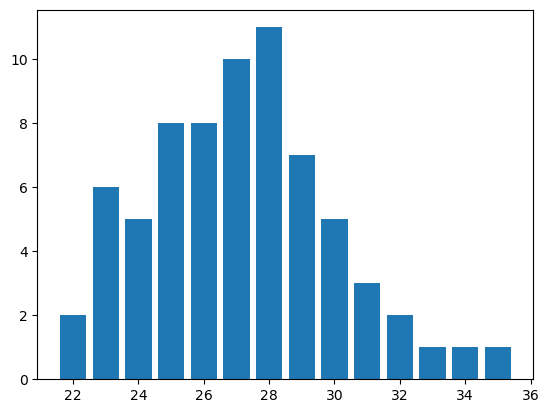

In [40]:
age_count_mvp = df_mvp.groupby("Age").size()
plt.bar(age_count_mvp.index, age_count_mvp.values)

####

## EDA - Players Information

In [41]:
df_player = pd.read_excel("Players_info.xlsx")
df_player.head()

,Name,From,To,Birth date,Death date,Age,Status,Colleges,Height,Weight,Position,Shoots,Current Team,Experience,Pts
0,Alaa Abdelnaby,1991,1995,1968-06-24,NaT,57.0,Retired,Duke,208,109.0,Power Forward,Right,NaN,NaN,5.7
1,Zaid Abdul-Aziz,1969,1978,1946-04-07,NaT,79.0,Retired,Iowa State,205,107.0,Center Power Forward,Right,NaN,NaN,9.0
2,Kareem Abdul-Jabbar*,1970,1989,1947-04-16,NaT,78.0,Retired,UCLA,218,102.0,NaN,NaN,NaN,NaN,NaN
3,Mahmoud Abdul-Rauf,1991,2001,1969-03-09,NaT,56.0,Retired,LSU,185,73.0,Point Guard,Right,NaN,NaN,14.6
4,Tariq Abdul-Wahad,1998,2003,1974-11-03,NaT,51.0,Retired,"Michigan, San Jose State",198,101.0,Shooting Guard,Right,NaN,NaN,7.8


In [42]:
df_player.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5384 entries, 0 to 5383
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Name          5384 non-null   object        
 1   From          5384 non-null   int64         
 2   To            5384 non-null   int64         
 3   Birth date    5373 non-null   datetime64[ns]
 4   Death date    1124 non-null   datetime64[ns]
 5   Age           5373 non-null   float64       
 6   Status        5384 non-null   object        
 7   Colleges      4982 non-null   object        
 8   Height        5384 non-null   int64         
 9   Weight        5379 non-null   float64       
 10  Position      5206 non-null   object        
 11  Shoots        5206 non-null   object        
 12  Current Team  514 non-null    object        
 13  Experience    514 non-null    float64       
 14  Pts           5206 non-null   float64       
dtypes: datetime64[ns](2), float64(4), int6

In [43]:
df_player.describe()

,From,To,Birth date,Death date,Age,Height,Weight,Experience,Pts
count,5384.000000,5384.000000,5373,1124,5373.000000,5384.000000,5379.000000,514.000000,5206.000000
mean,1990.830609,1995.094911,1967-07-26 11:12:09.648241200,2007-04-27 05:07:28.398576640,54.099758,197.656389,95.074735,4.694553,5.994583
min,1947.000000,1947.000000,1902-01-30 00:00:00,1958-02-01 00:00:00,19.000000,160.000000,52.000000,0.000000,0.000000
25%,1972.000000,1976.000000,1948-10-16 00:00:00,1998-11-07 18:00:00,36.000000,190.000000,86.000000,1.000000,2.800000
50%,1993.000000,1999.000000,1969-01-25 00:00:00,2010-02-02 00:00:00,55.000000,198.000000,95.000000,4.000000,5.000000
75%,2012.000000,2018.000000,1989-02-28 00:00:00,2018-04-03 12:00:00,71.000000,205.000000,102.000000,7.000000,8.200000
max,2026.000000,2026.000000,2006-12-21 00:00:00,2025-12-22 00:00:00,109.000000,231.000000,163.000000,22.000000,28.900000
std,23.505287,24.199027,NaN,NaN,20.296520,9.140982,11.771138,4.334693,4.339418


In [44]:
shape = df_player.shape
print(f"The number of rows is {shape[0]}, and the number of columns is {shape[1]}.")

The number of rows is 5384, and the number of columns is 15.


In [45]:
columns = df_player.columns
print(f"{len(columns)} Columns:")
for col in columns:
    print(col)

15 Columns:
Name
From
To
Birth date
Death date
Age
Status
Colleges
Height
Weight
Position
Shoots
Current Team
Experience
Pts


#### *Status*

In [46]:
print(f"Status: {df_player["Status"].dropna().unique()}")
df_player["Status"].value_counts().reset_index()

Status: ['Retired' 'Deceased' 'Active']


,Status,count
0,Retired,3733
1,Deceased,1137
2,Active,514


#### *Shoot*

In [47]:
print(f"Shoots: {df_player["Shoots"].dropna().unique()}")
df_player["Shoots"].value_counts().reset_index()

Shoots: ['Right' 'Left' 'Right Left' 'Left Right']


,Shoots,count
0,Right,4848
1,Left,356
2,Right Left,1
3,Left Right,1


#### *Teams*

In [48]:
unique_team_count = df_player["Current Team"].dropna().unique()
print(f"count of teams: {len(unique_team_count)}\n{unique_team_count}")

count of teams: 30
['Sacramento Kings' 'Houston Rockets' 'Miami Heat' 'Toronto Raptors'
 'Memphis Grizzlies' 'New Orleans Pelicans' 'Atlanta Hawks' 'Phoenix Suns'
 'Cleveland Cavaliers' 'Utah Jazz' 'Milwaukee Bucks' 'New York Knicks'
 'Portland Trail Blazers' 'Los Angeles Lakers' 'Washington Wizards'
 'Charlotte Hornets' 'Orlando Magic' 'Philadelphia ' 'San Antonio Spurs'
 'Oklahoma City Thunder' 'Los Angeles Clippers' 'Minnesota Timberwolves'
 'Boston Celtics' 'Indiana Pacers' 'Denver Nuggets'
 'Golden State Warriors' 'Chicago Bulls' 'Dallas Mavericks'
 'Brooklyn Nets' 'Detroit Pistons']


In [49]:
df_player["Current Team"].value_counts().reset_index()

,Current Team,count
0,Memphis Grizzlies,19
1,Sacramento Kings,18
2,New Orleans Pelicans,18
3,Toronto Raptors,18
4,New York Knicks,18
5,Cleveland Cavaliers,18
6,Indiana Pacers,18
7,Chicago Bulls,18
8,Charlotte Hornets,18
9,Detroit Pistons,18


#### Age

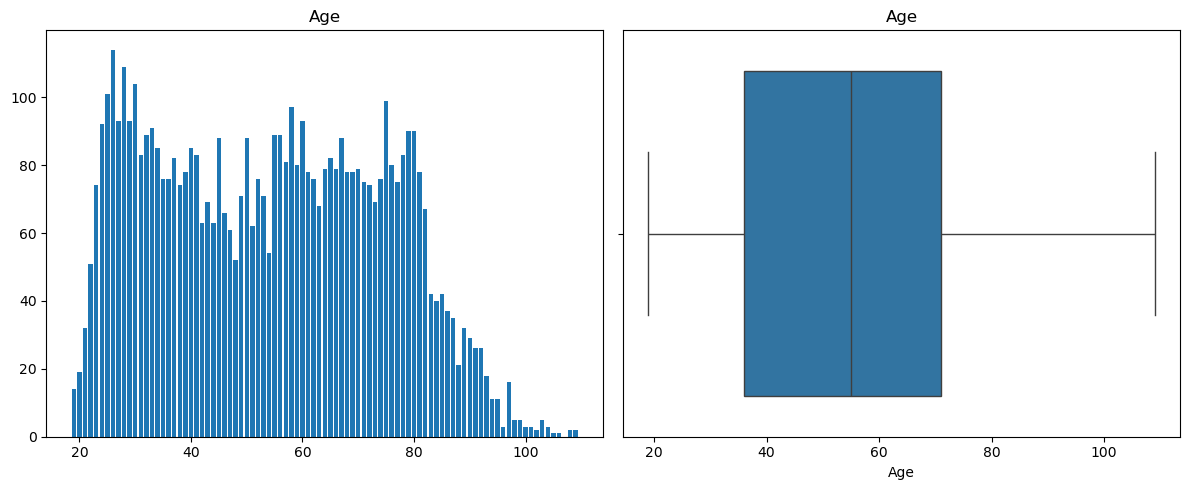

In [50]:
show_plot(df_player,"Age")

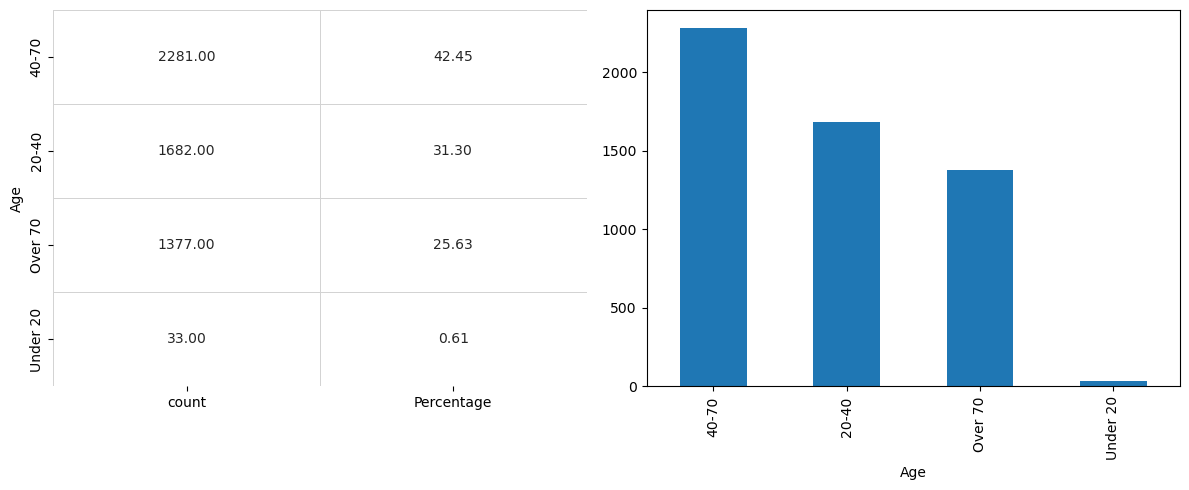

In [51]:
bins = [0,20,40,70,115]
labels = ["Under 20","20-40", "40-70","Over 70"]
binning(df_player,"Age",bins, labels)

#### *Height*

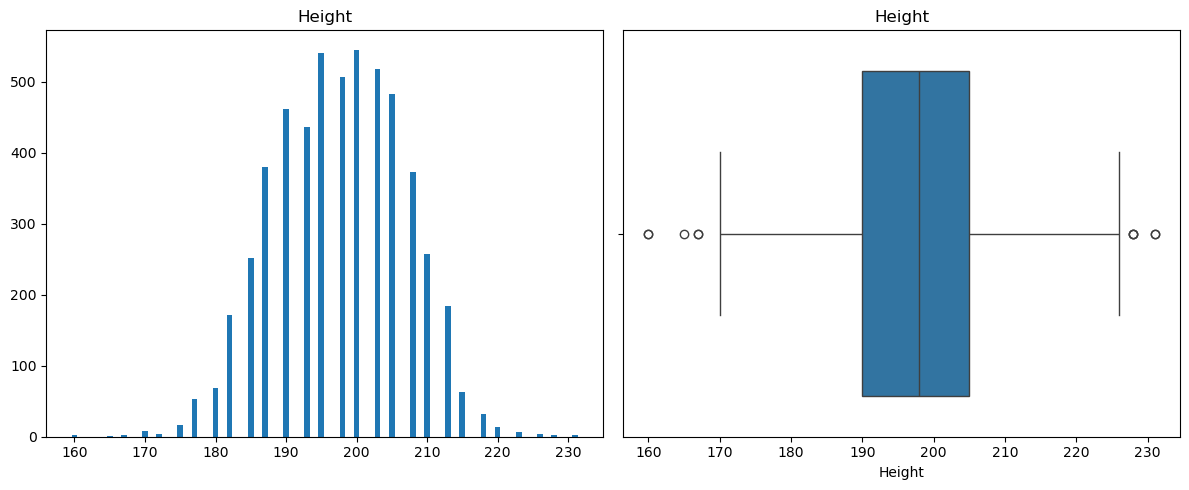

In [52]:
show_plot(df_player,"Height")

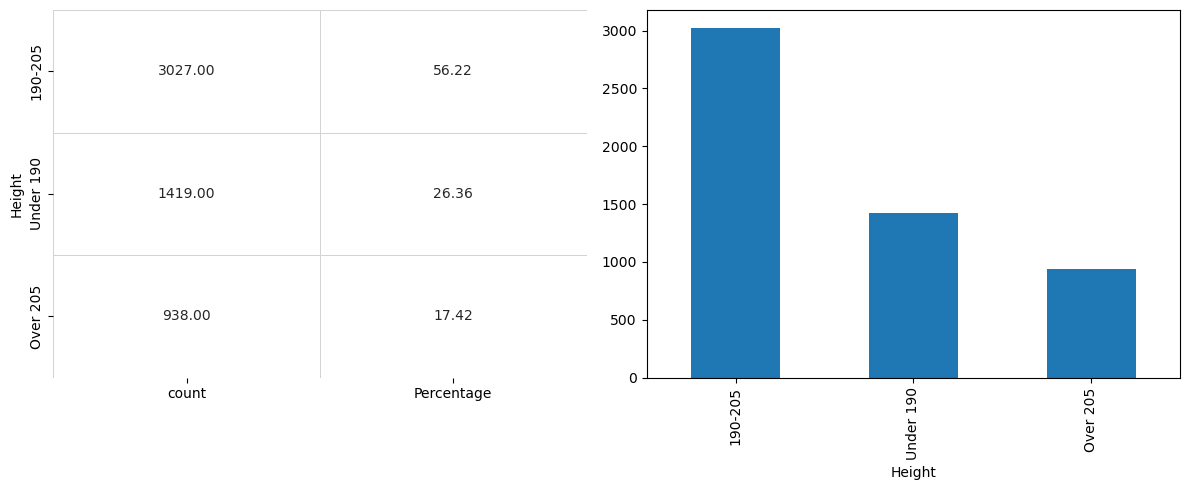

In [53]:
bins = [0,190,205,240]
labels = ["Under 190", "190-205", "Over 205"]
binning(df_player,"Height",bins, labels)

#### Height vs PTS

PTS Average = 5.99


<Axes: xlabel='Height'>

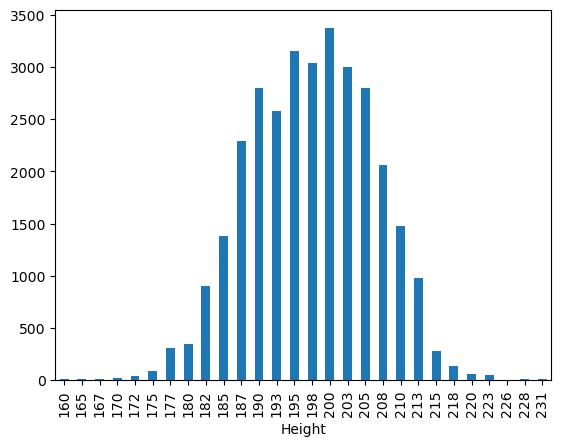

In [54]:
pts_avg = np.average(df_player["Pts"].dropna())
print(f"PTS Average = {pts_avg:.2f}")

height_pts = df_player.groupby(["Height"])["Pts"].sum()
height_pts.plot(kind='bar')

#### *Weight*

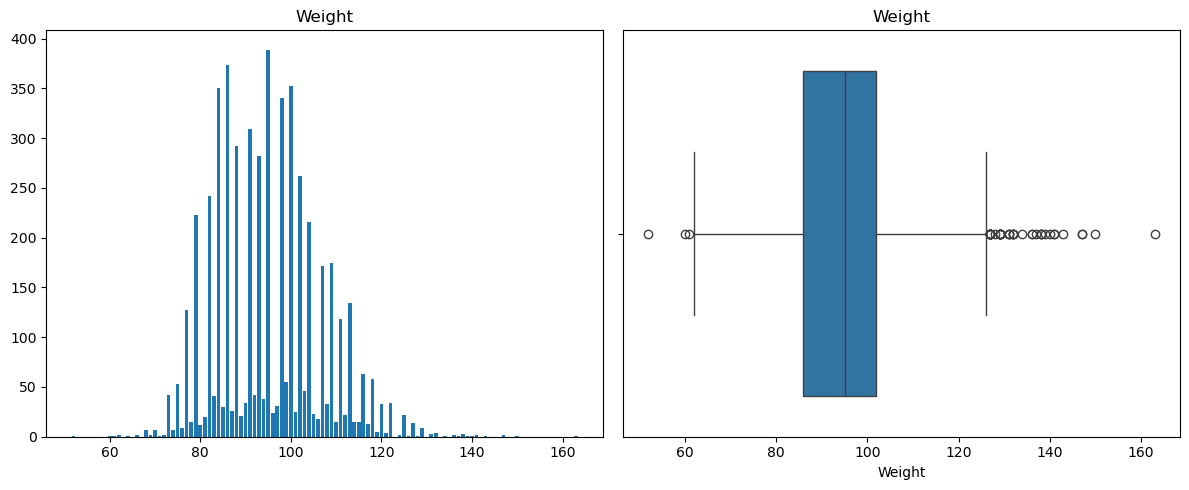

In [55]:
show_plot(df_player,"Weight")

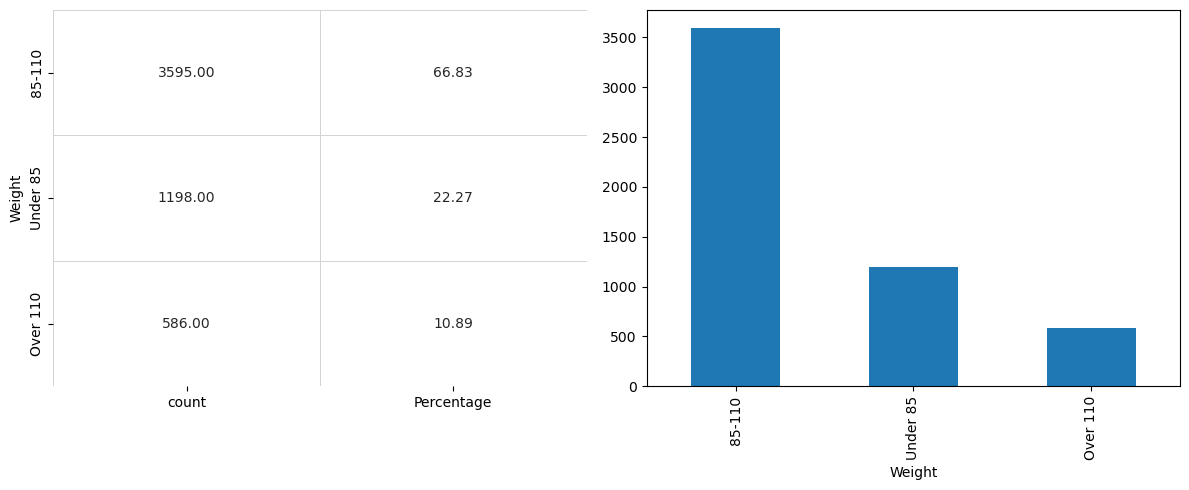

In [56]:
bins = [0,85,110,170]
labels = ["Under 85", "85-110", "Over 110"]
binning(df_player,"Weight",bins, labels)

#### Weight vs PTS

PTS Average = 5.99


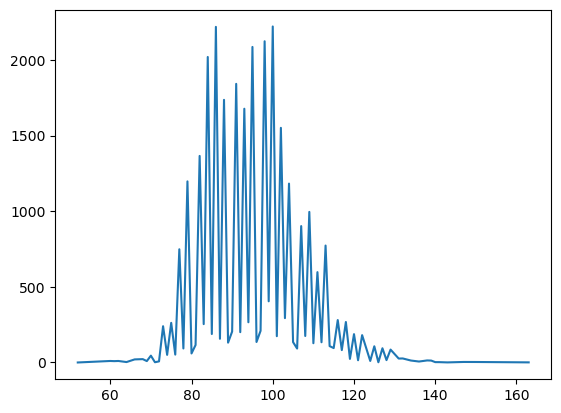

In [57]:
pts_avg = np.average(df_player["Pts"].dropna())
print(f"PTS Average = {pts_avg:.2f}")

height_pts = df_player.groupby(["Weight"])["Pts"].sum()
plt.plot(height_pts)
#height_pts.plot(kind='bar')

### Active Player

In [58]:
active_player = df_player[df_player["Status"] == "Active"]

Average Of Age Active Player: 26.01


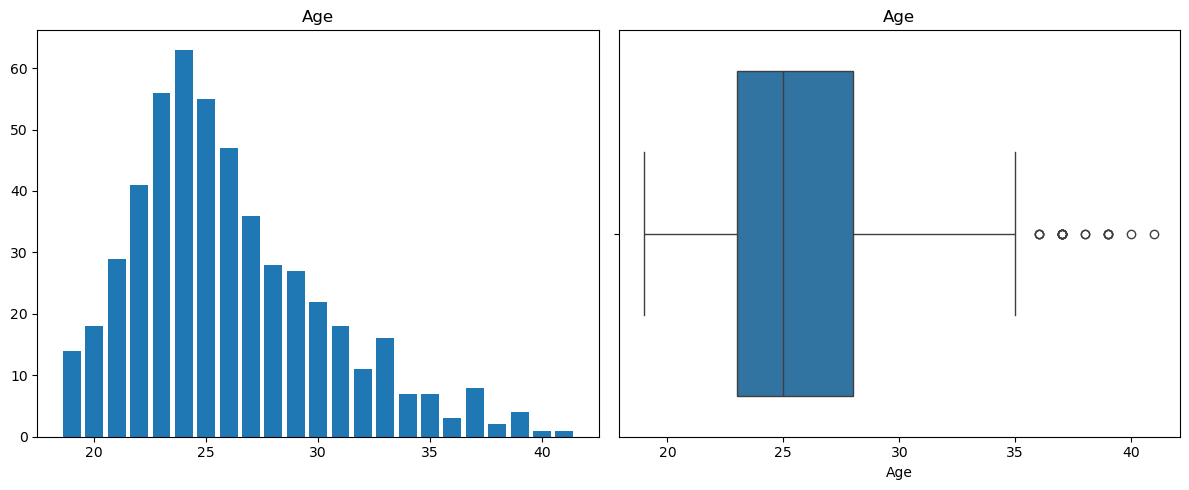

In [59]:
# -------- Age of Active Player ---------
print(f"Average Of Age Active Player: {np.average(active_player["Age"]):.2f}")
show_plot(active_player,"Age")

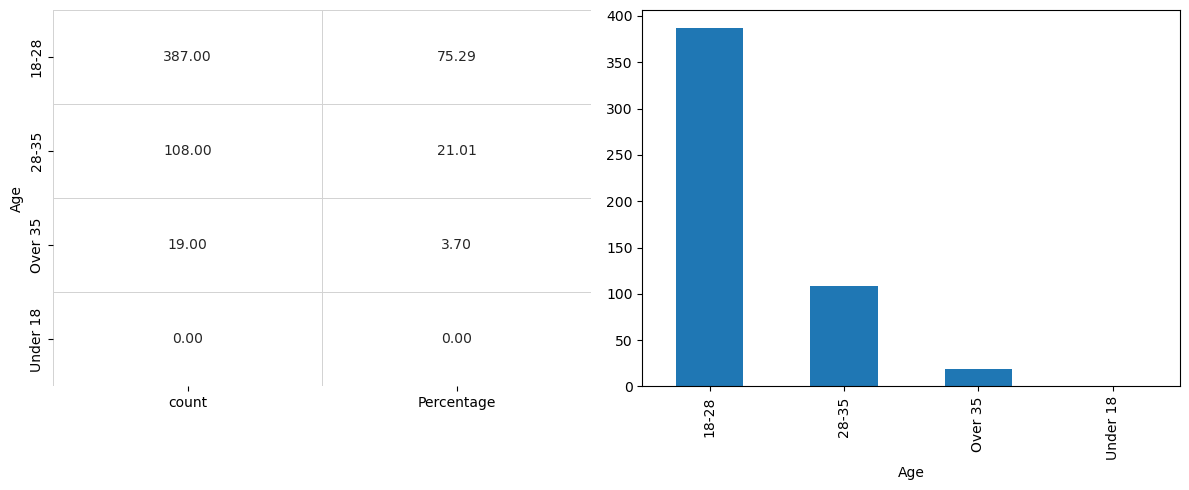

In [60]:
bins = [0,18,28,35,45]
labels = ["Under 18", "18-28", "28-35","Over 35"]
binning(active_player,"Age",bins, labels)

Average Of Pts Active Player: nan


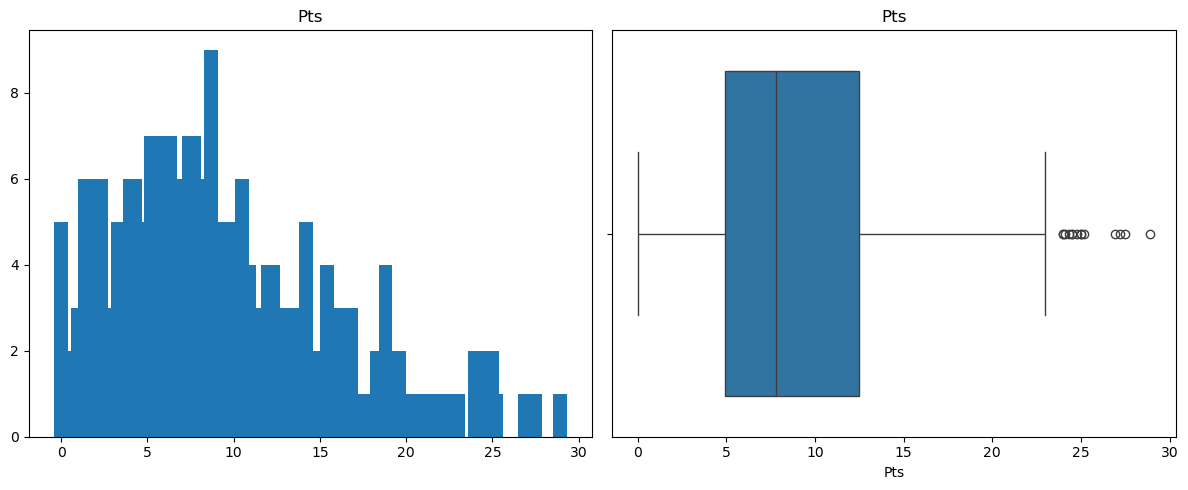

In [61]:
# -------- PTS of Active Player ---------
print(f"Average Of Pts Active Player: {np.average(active_player["Pts"]):.2f}")
show_plot(active_player,"Pts")

Average Of Experience Active Player: 4.69


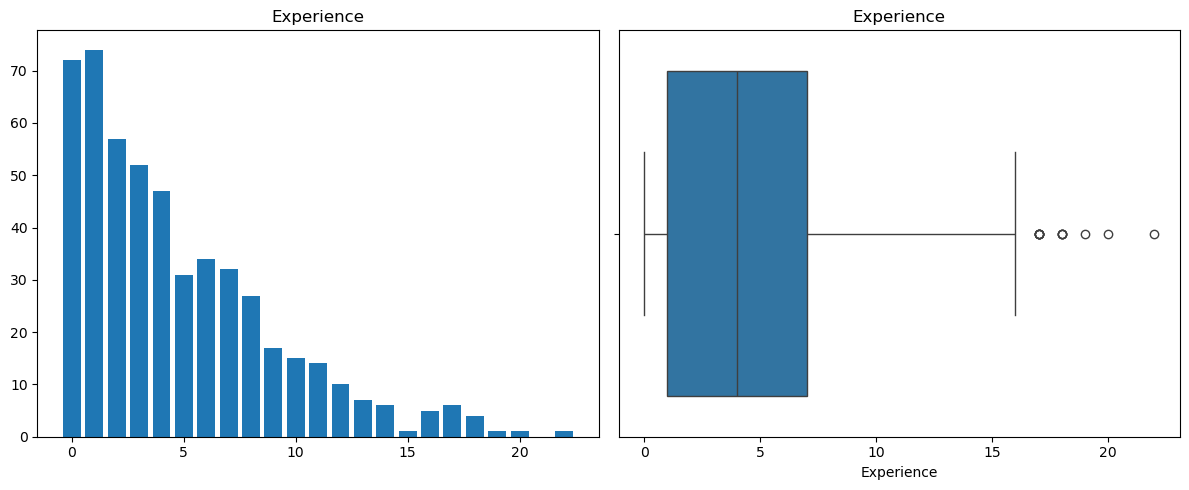

In [62]:
# -------- Experience of Active Player ---------
print(f"Average Of Experience Active Player: {np.average(active_player["Experience"]):.2f}")
show_plot(active_player,"Experience")

In [63]:
experience_active_player = active_player.groupby(["Experience"]).size().to_frame()
experience_active_player["Percentage"] = (experience_active_player / experience_active_player.sum()) * 100
experience_active_player

,0,Percentage
Experience,,
0.0,72,14.007782
1.0,74,14.396887
2.0,57,11.089494
3.0,52,10.116732
4.0,47,9.143969
5.0,31,6.031128
6.0,34,6.614786
7.0,32,6.225681
8.0,27,5.252918


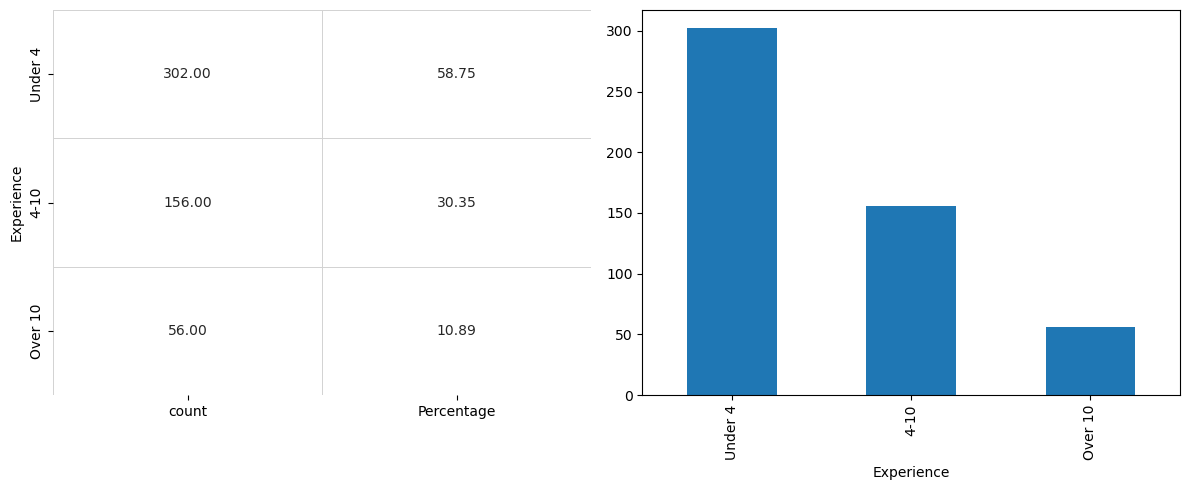

In [64]:
bins = [0,4,10,23]
labels = ["Under 4", "4-10", "Over 10"]
binning(active_player,"Experience",bins, labels)

### New Player

In [65]:
# Join 2026
new_player = active_player[active_player["Experience"] == 0.0]
print(f"Count of New Player(Join 2026): {len(new_player)}")

new_player_age = active_player[active_player["Experience"] == 0.0]["Age"]
new_player_age = new_player_age.value_counts().to_frame()
new_player_age["Percentage"] = (new_player_age / new_player_age.sum()) * 100
new_player_age

Count of New Player(Join 2026): 72


,count,Percentage
Age,,
23.0,16,22.222222
24.0,15,20.833333
19.0,14,19.444444
20.0,10,13.888889
22.0,8,11.111111
21.0,6,8.333333
26.0,2,2.777778
25.0,1,1.388889


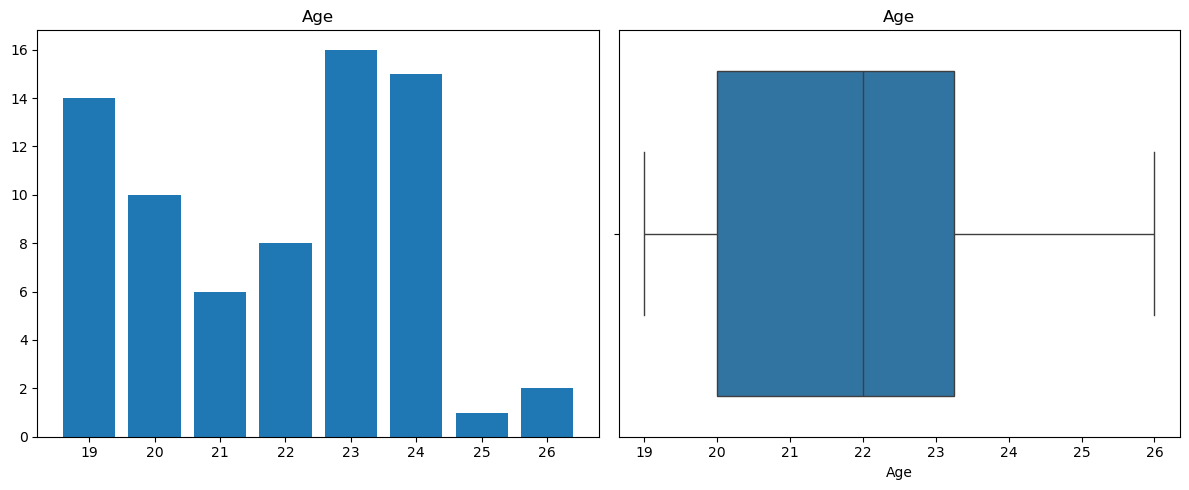

In [66]:
# ---- new Player Age Plot -----
show_plot(new_player, "Age")

In [67]:
team_new_player  = active_player[active_player["Experience"] == 0.0]["Current Team"]  # teams name
name_new_player  = active_player[active_player["Experience"] == 0.0]["Name"]   # Player's Name